## Описание проекта
В нашем распоряжении около 10 млн записей о поездках такси в Чикаго и перед нами стоит задача предсказать количество заказов на следующий час в каждом округе. Решать ее мы будем с применением PySpark на локальном кластере из Docker контейнеров.

In [ ]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=d8bc904b07d775293a43ccb683224d39ae4d9cb3f97e9816965794bfdb71a857
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark import SparkFiles
from pyspark.sql import SparkSession

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
SPARK_MASTER_IP = '172.18.0.2'
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 2) \
    .config("spark.task.cpus", 2) \
    .getOrCreate()


In [ ]:
schema = StructType([
    StructField("trip_id", StringType(), nullable=True),
    StructField("taxi_id", StringType(), nullable=True),
    StructField("trip_start_timestamp", TimestampType(), nullable=True),
    StructField("trip_end_timestamp", TimestampType(), nullable=True),
    StructField("trip_seconds", FloatType(), nullable=True),
    StructField("trip_miles", FloatType(), nullable=True),
    StructField("pickup_census_tract", StringType(), nullable=True),
    StructField("dropoff_census_tract", StringType(), nullable=True),
    StructField("pickup_community_area", IntegerType(), nullable=True),
    StructField("dropoff_community_area", IntegerType(), nullable=True),
    StructField("fare", StringType(), nullable=True),
    StructField("tips", StringType(), nullable=True),
    StructField("tolls", StringType(), nullable=True),
    StructField("extras", StringType(), nullable=True),
    StructField("trip_total", StringType(), nullable=True),
    StructField("payment_type", StringType(), nullable=True),
    StructField("company", StringType(), nullable=True),
    StructField("pickup_centroid_latitude", FloatType(), nullable=True),
    StructField("pickup_centroid_longitude", FloatType(), nullable=True),
    StructField("pickup_centroid_location", StringType(), nullable=True),
    StructField("dropoff_centroid_latitude", FloatType(), nullable=True),
    StructField("dropoff_centroid_longitude", FloatType(), nullable=True),
    StructField("dropoff_centroid_location", StringType(), nullable=True)]
)

In [ ]:
data = spark.read.load('Taxi_Trips_-_2022.csv', format='csv', sep=',', header=True)

In [ ]:
df.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: float (nullable = true)
 |-- trip_miles: float (nullable = true)
 |-- pickup_census_tract: string (nullable = true)
 |-- dropoff_census_tract: string (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: string (nullable = true)
 |-- tips: string (nullable = true)
 |-- tolls: string (nullable = true)
 |-- extras: string (nullable = true)
 |-- trip_total: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: float (nullable = true)
 |-- pickup_centroid_longitude: float (nullable = true)
 |-- pickup_centroid_location: string (nullable = true)
 |-- dropoff_centroid_latitude: float (nullable = true)
 |-- dropoff_centr

In [ ]:
# Удаление строк с NULL значением в столбце "Pickup Community Area"
df = df.dropna(subset=["fare"])
df = df.dropna(subset=["pickup_community_area"])
df = df.dropna(subset=["trip_seconds"])
df = df.dropna(subset=["trip_miles"])
df = df.fillna({'dropoff_community_area': 78})


## Графики

In [ ]:
def plot_trips_by_year(df, area):
    """
    График отображает количество поездок по неделям в течении года
    с использованием скользящего среднего за 4 недели.

    Args:
    df (DataFrame): Spark DataFrame.
    area (int): The pickup community area.
    """
    # Фильтрация данных для указанного района
    df_subset = df.filter(df["pickup_community_area"] == area)

    # Преобразование Spark DataFrame в pandas DataFrame
    pandas_df = df_subset.toPandas()

    # Преобразование колонки 'trip_start_timestamp' в тип datetime
    pandas_df['trip_start_timestamp'] = pd.to_datetime(pandas_df['trip_start_timestamp']).astype('datetime64[ns]')

    # Добавление столбца 'count', где каждая запись равна 1
    pandas_df['count'] = 1

    # Группировка данных по неделе и подсчёт количества записей
    weekly_data = pandas_df.resample('W', on='trip_start_timestamp').sum(numeric_only=True)

    # Вычисление скользящего среднего
    weekly_data['count_ma'] = weekly_data['count'].rolling(window=4).mean()

    # Построение графика с использованием seaborn
    plt.figure(figsize=(12, 6))

    # График количества поездок по неделям со скользящим средним
    sns.lineplot(x=weekly_data.index, y="count_ma", data=weekly_data, marker='o')

    # Настройка деталей графика
    plt.xlabel("Неделя")
    plt.ylabel("Количество поездок")
    plt.title(f"Еженедельное количество поездок для района {area}")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Отображение графика
    plt.show()


In [ ]:
def plot_trips_by_month(df, area):
    """
    График количества поездок по месяцам

    Args:
    df (DataFrame): Spark DataFrame.
    area (int): The pickup community area.
    """
    # Фильтрация данных для указанного района
    df_subset = df.filter(df["pickup_community_area"] == area)

    # Извлечение года и месяца из trip_start_timestamp
    df_grouped = df_subset.withColumn("year", year("trip_start_timestamp")) \
                          .withColumn("month", month("trip_start_timestamp")) \
                          .groupBy("year", "month") \
                          .count() \
                          .orderBy("year", "month")

    # Конвертация в df pandas
    pandas_df = df_grouped.toPandas()

    # Настройка sns
    sns.set(style="whitegrid")

    # Сооздание графика за 2022 год
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(pandas_df["month"], pandas_df["count"], marker='o', linestyle='none')
    plt.xlabel("Месяц")
    plt.ylabel("Кол. поездок")
    plt.title(f"Кол. поездок за каждый месяц в 2022 в районе {area}")
    plt.xticks(range(1, 13), ["Янв", "Фев", "Март", "Апр", "Май", "Июнь", "Июль", "Авг", "Сен", "Окт", "Нояб", "Дек"])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_trips_by_hour(df, area):
    """
    График поездок за день для каждого района

    Args:
    df (DataFrame): Spark DataFrame.
    area (int): The pickup community area.
    """
    # Фильтрация данных для указанного района
    df_subset = df.filter(df["pickup_community_area"] == area)

    # Групировка данных за каждый час
    df_grouped = df_subset.groupBy(hour("trip_start_timestamp").alias('hour')).count().orderBy('hour')

    # Конвертация в pandas DataFrame
    pandas_df = df_grouped.toPandas()

    # Конвертация 'hour' в datetime
    pandas_df['trip_start_timestamp'] = pd.to_datetime(pandas_df['hour'], format='%H')

    # Сортировка по времени для корректного отображения графика
    pandas_df = pandas_df.sort_values('trip_start_timestamp')

    # График
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="trip_start_timestamp", y="count", data=pandas_df, marker='o', color='royalblue', linewidth=2.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.xlabel("Час дня", fontsize=14, labelpad=15)
    plt.ylabel("количество заказов", fontsize=14, labelpad=15)
    plt.title(f"Количество заказов за час для района {area}", fontsize=16, pad=20)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_fare_by_hour(df, area):
    """
    График суммы тарифов за день для каждого района

    Args:
    df (DataFrame): Spark DataFrame.
    area (int): The pickup community area.
    """
    # Фильтрация данных для указанного района
    df_subset = df.filter(df["pickup_community_area"] == area)

    df_subset = df_subset.withColumn("fare", col("fare").cast(IntegerType()))

    # Группировка данных за каждый час и суммирование тарифов
    df_grouped = df_subset.groupBy(hour("trip_start_timestamp").alias('hour')).sum("fare").orderBy('hour')

    # Конвертация в pandas DataFrame
    pandas_df = df_grouped.toPandas()

    # Переименование столбца с суммой тарифов
    pandas_df.rename(columns={"sum(fare)": "total_fare"}, inplace=True)

    # Конвертация 'hour' в datetime
    pandas_df['trip_start_timestamp'] = pd.to_datetime(pandas_df['hour'], format='%H')

    # Сортировка по времени для корректного отображения графика
    pandas_df = pandas_df.sort_values('trip_start_timestamp')

    # График
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="trip_start_timestamp", y="total_fare", data=pandas_df, marker='o', color='royalblue', linewidth=2.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.xlabel("Час дня", fontsize=14, labelpad=15)
    plt.ylabel("Сумма тарифов", fontsize=14, labelpad=15)
    plt.title(f"Сумма тарифов для {area}", fontsize=16, pad=20)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


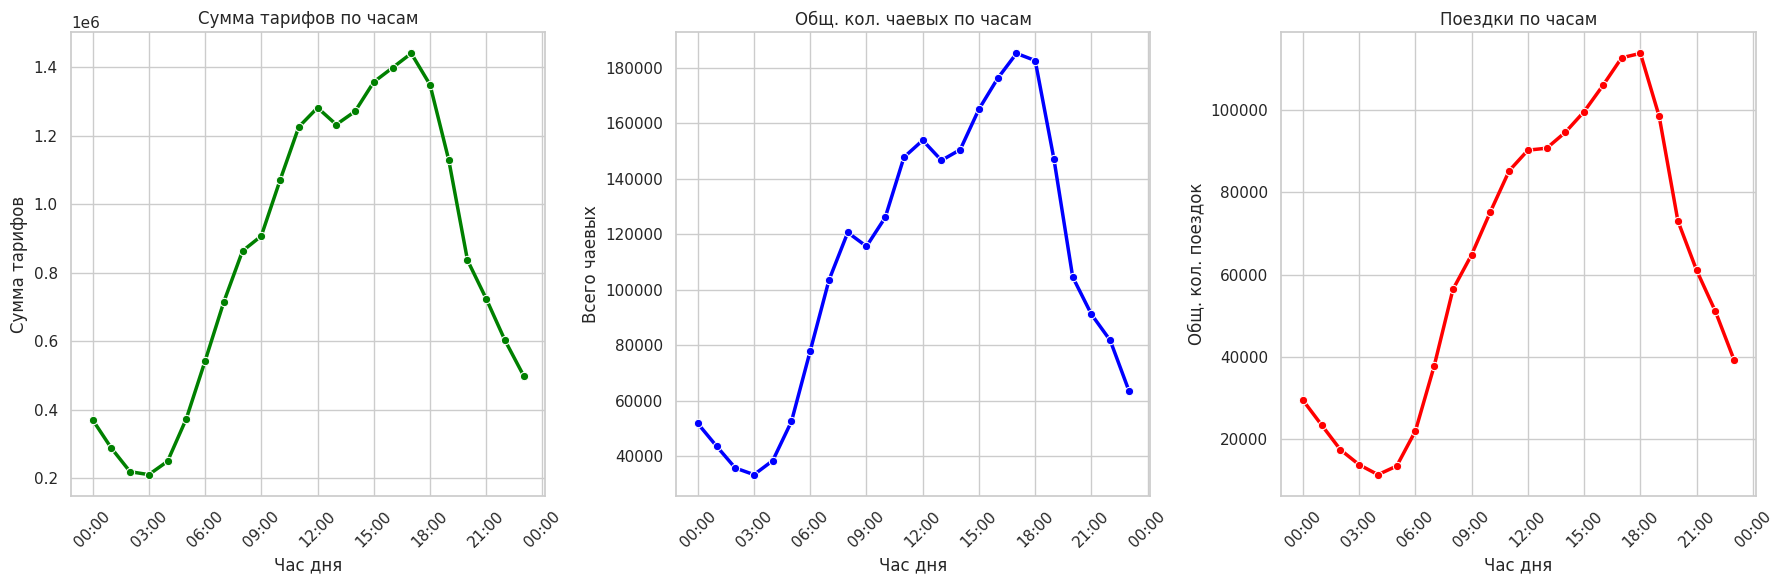

In [ ]:
area = 8  # Пример района

# Фильтрация данных для района
df_subset = df.filter(df["pickup_community_area"] == area)

df_subset = df_subset.withColumn("fare", col("fare").cast(IntegerType()))
df_subset = df_subset.withColumn("tips", col("tips").cast(IntegerType()))

# Группировка данных за каждый час
df_grouped = df_subset.groupBy(hour("trip_start_timestamp").alias('hour'))\
    .agg(
        sum("fare").alias("total_fare"),
        sum("tips").alias("total_tips"),
        count("trip_id").alias("trip_count")
    )\
    .orderBy('hour')

# Конвертация в pandas DataFrame
pandas_df = df_grouped.toPandas()

# Конвертация 'hour' в datetime
pandas_df['trip_start_timestamp'] = pd.to_datetime(pandas_df['hour'], format='%H')

# Сортировка по времени
pandas_df = pandas_df.sort_values('trip_start_timestamp')

# Создание трех графиков
plt.figure(figsize=(18, 6))

# График тарифа
plt.subplot(1, 3, 1)
sns.lineplot(x="trip_start_timestamp", y="total_fare", data=pandas_df, marker='o', color='green', linewidth=2.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Час дня")
plt.ylabel("Сумма тарифов")
plt.title("Сумма тарифов по часам")
plt.xticks(rotation=45)
plt.grid(True)

# График чаевых
plt.subplot(1, 3, 2)
sns.lineplot(x="trip_start_timestamp", y="total_tips", data=pandas_df, marker='o', color='blue', linewidth=2.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Час дня")
plt.ylabel("Всего чаевых")
plt.title("Общ. кол. чаевых по часам")
plt.xticks(rotation=45)
plt.grid(True)

# График количества поездок
plt.subplot(1, 3, 3)
sns.lineplot(x="trip_start_timestamp", y="trip_count", data=pandas_df, marker='o', color='red', linewidth=2.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Час дня")
plt.ylabel("Общ. кол. поездок")
plt.title("Поездки по часам")
plt.xticks(rotation=45)
plt.grid(True)


plt.tight_layout()
plt.show()

Три графика по часам для одного из центральных районов Чикаго.  

График "Стоимость проезда по часам" (зеленый):

*   Пиковое значение в 12 часов, в обеденное время стоймость поездки дорожает.
*   Пиковое значение 17 часов под конец рабочего дня, также стоймость поездки дорожает.
*   Больше всего заработали в период с 12 до 18 часов.
*   Меньше всего заработали в ночное время.

График "Кол. чаевых по часам" (синий):

*   Пик в 8 утра может соответствовать утреннему час пику, когда многие люди едут на работу или в школу и с большей вероятностью дают чаевые своим водителям.
*   Пик в 12 часов дня приходится на обеденное время, когда люди, возможно, отправляются куда-нибудь пообедать и могут быть более склонны давать чаевые.
*   Пик в 17 часов, когда люди возвращаются домой с работы, также вероятно оставят чаевые.

График "Поездки по часам" (красный):

*   Здесь также виден пик активности в период с 14:00 до 20:00, что подтверждает, что это самое оживленное время для такси в центральном районе Чикаго.
*   Самое маленькое количество поездок происходит около 03:00 - 05:00, что является обычным для городских районов, где ночная активность снижается.  

Общие выводы:  

Время с 14:00 до 20:00 является самым загруженным и прибыльным для таксистов в центральном районе Чикаго, судя по всем трём графикам.
Ночные и ранние утренние часы характеризуются низкой активностью и могут быть не самым эффективным временем для работы таксистов в этом районе.
Стоймость проездка в пиковое время больше, что видно из пиков на первом графике, в то время как на 3 графике они сглажены.









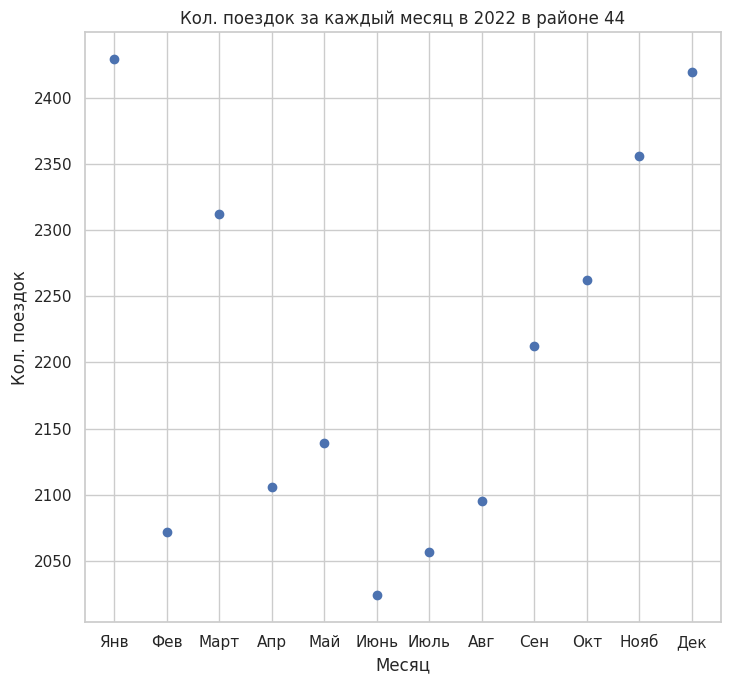

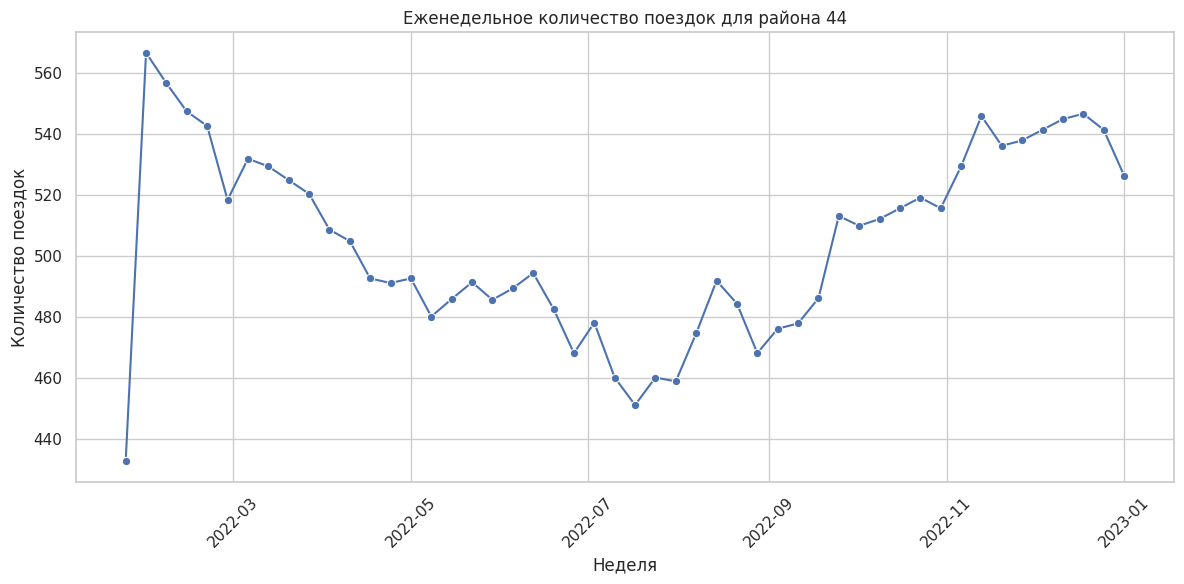

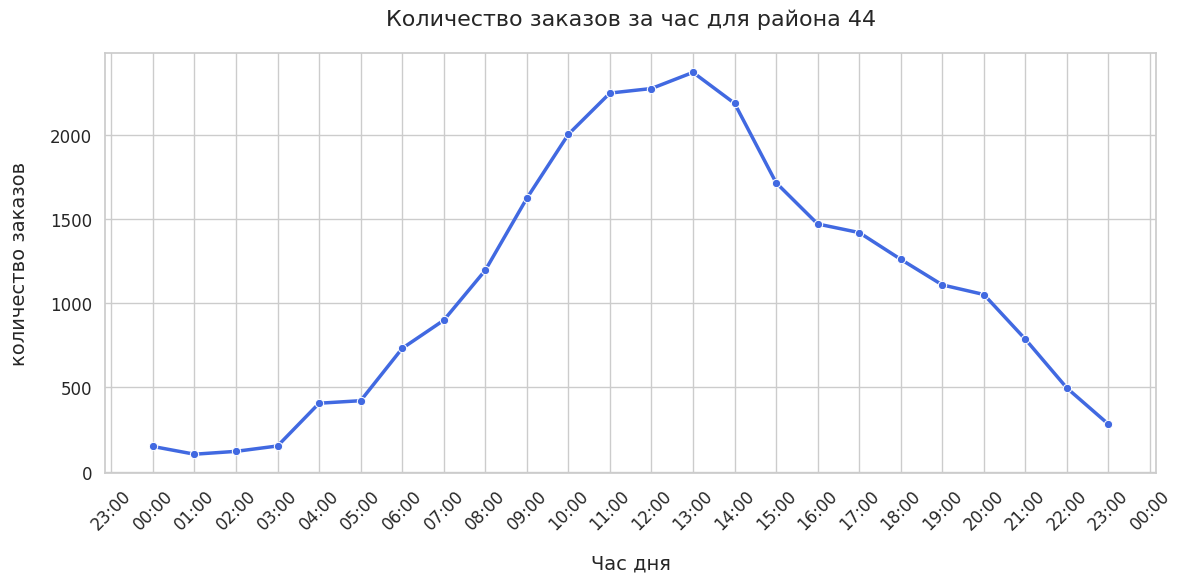

Рассмотрим один из южно-восточных райнов.
В отличии от центральных райнов, здесь такси используют в более холодное время года,
реже всего в июне, а чеще всего в декабре и январе


In [ ]:
plot_trips_by_month(df, 44), plot_trips_by_year(df, 44), plot_trips_by_hour(df, 44)
print('Рассмотрим один из южно-восточных райнов.')
print('В отличии от центральных райнов, здесь такси используют в более холодное время года,')
print('реже всего в июне, а чеще всего в декабре и январе')

График для одного из отдаленных юго-западных районов Чикаго


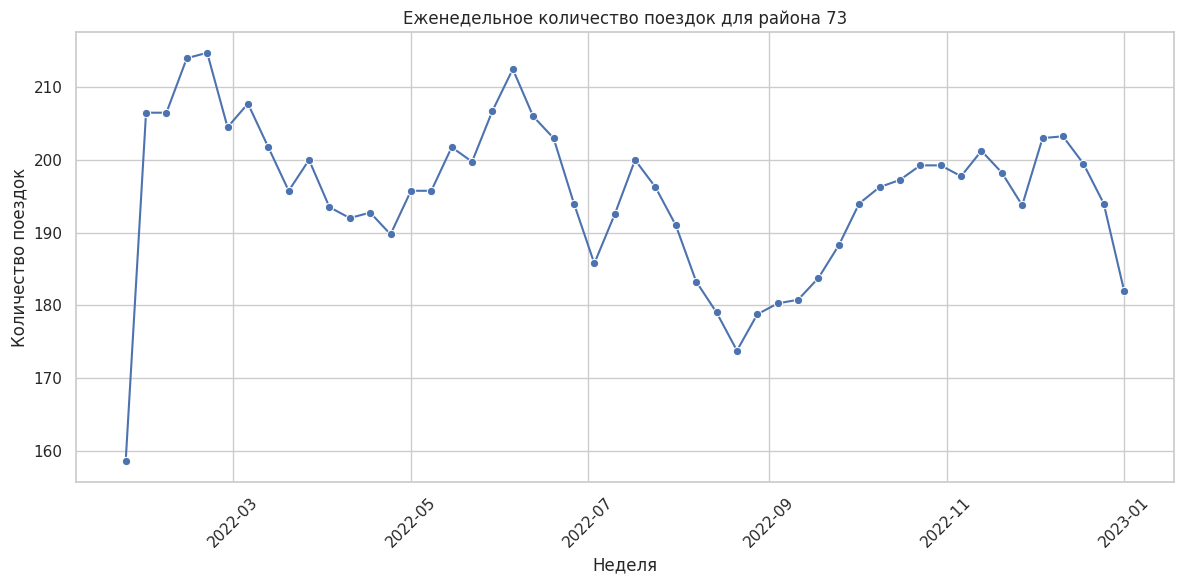

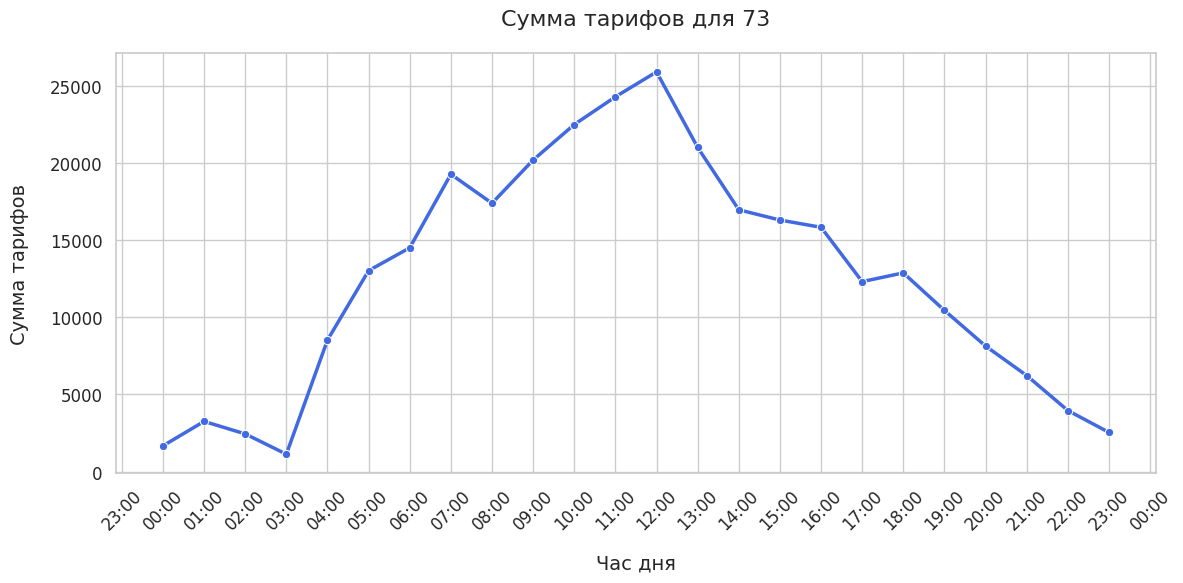

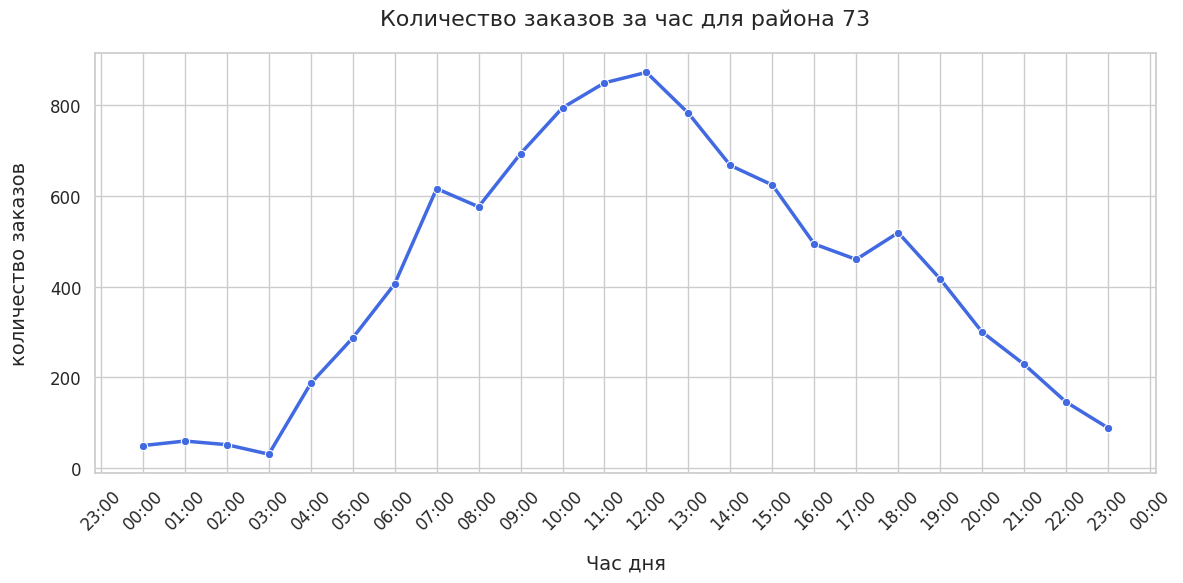

Сильно мало заказов в конце августа и начале сентября.
Самым прибыльные часы: Утро, обед и конец рабочего дня.


In [ ]:
print('График для одного из отдаленных юго-западных районов Чикаго')
plot_trips_by_year(df, 73), plot_fare_by_hour(df, 73), plot_trips_by_hour(df, 73)
print('Сильно мало заказов в конце августа и начале сентября.')
print('Самым прибыльные часы: Утро, обед и конец рабочего дня.')

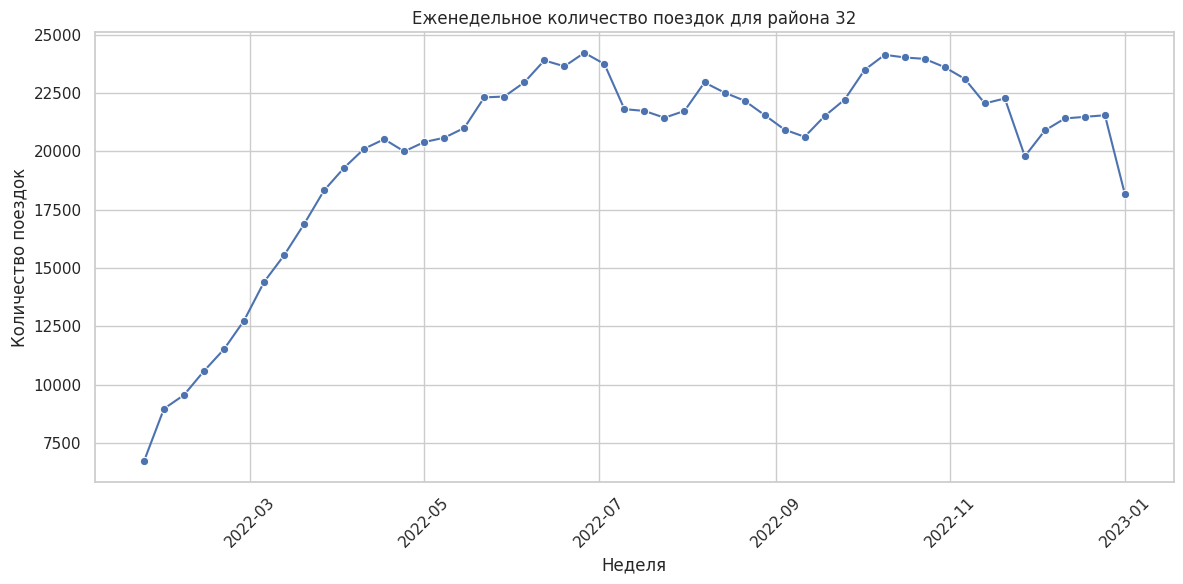

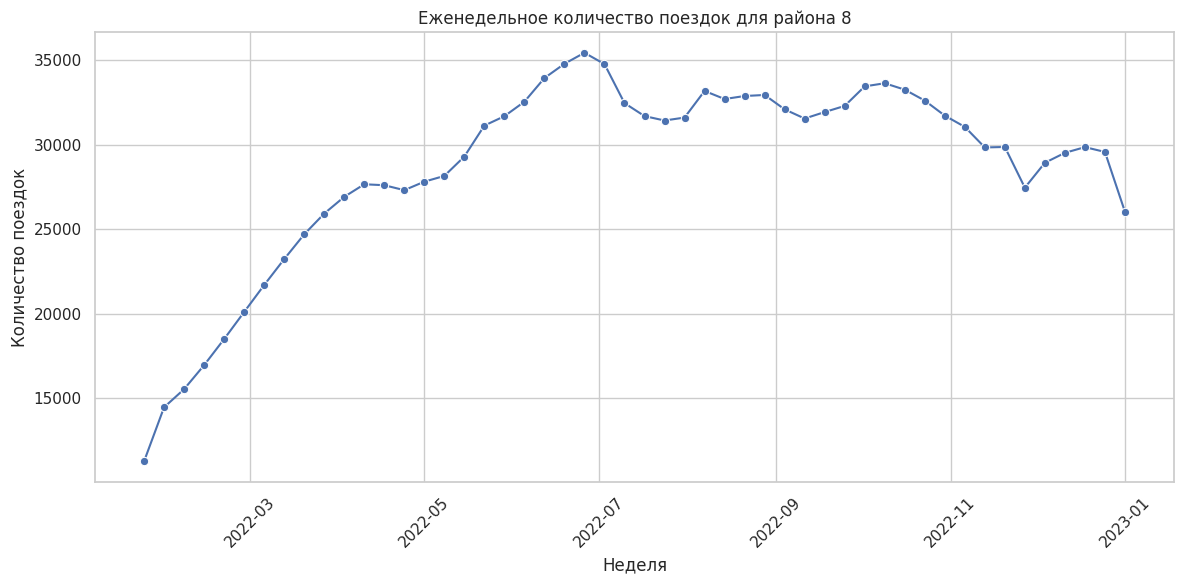

(None, None)

In [ ]:
plot_trips_by_year(df, 32), plot_trips_by_year(df, 8)

Оба графика отображают еженедельное количество поездок для центральных районов Чикаго (район 8 и район 32) на протяжении примерно одного года (с марта 2022 по март 2023).

На обоих графиках виден рост числа поездок с марта по июнь 2022 года, что может указывать на сезонное увеличение спроса или на постепенное восстановление активности после COVID-19.

После июня 2022 года количество поездок стабилизируется с некоторыми колебаниями вверх и вниз, что может быть связано с нормальными сезонными изменениями или другими внешними факторами, влияющими на потребность в поездках.

На графике района 8 виден резкий спад в конце периода (март 2023), что может указывать на какое-то событие или изменение условий, негативно повлиявшее на число поездок (например, новые ограничения, погодные условия, изменение транспортной сети).

В то время как график района 32 также показывает спад в конце периода, он не такой резкий, как в районе 8, что может свидетельствовать о том, что влияющие факторы различаются между районами или о том, что район 32 менее подвержен этим факторам.

Максимальное количество поездок для района 8 выше, чем для района 32, что может указывать на большую популярность или населенность района 8.



Отдаленные юго-западные районы имеют мало данных, имеет смысл объеденить их в один регион


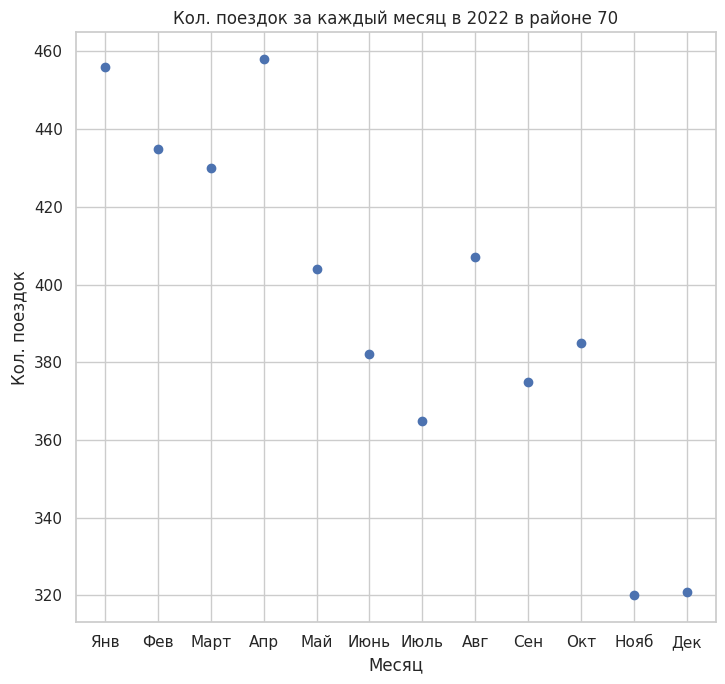

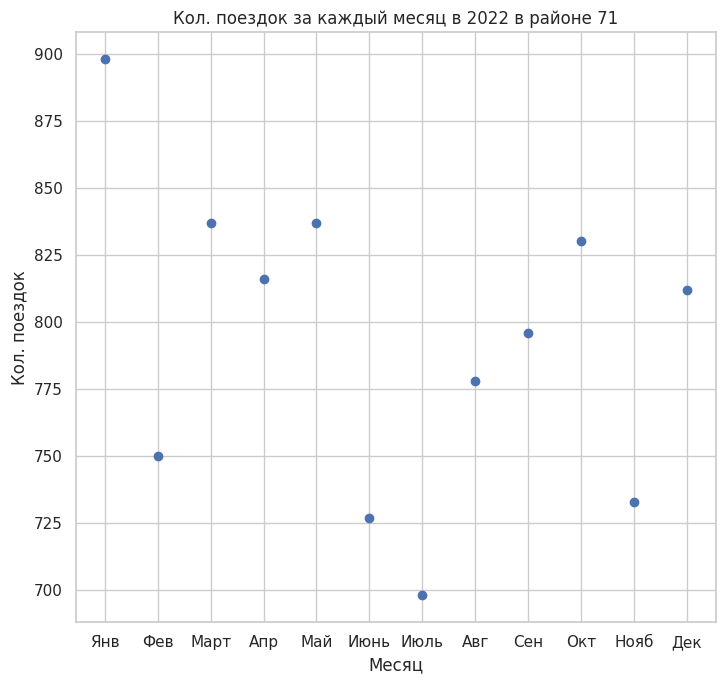

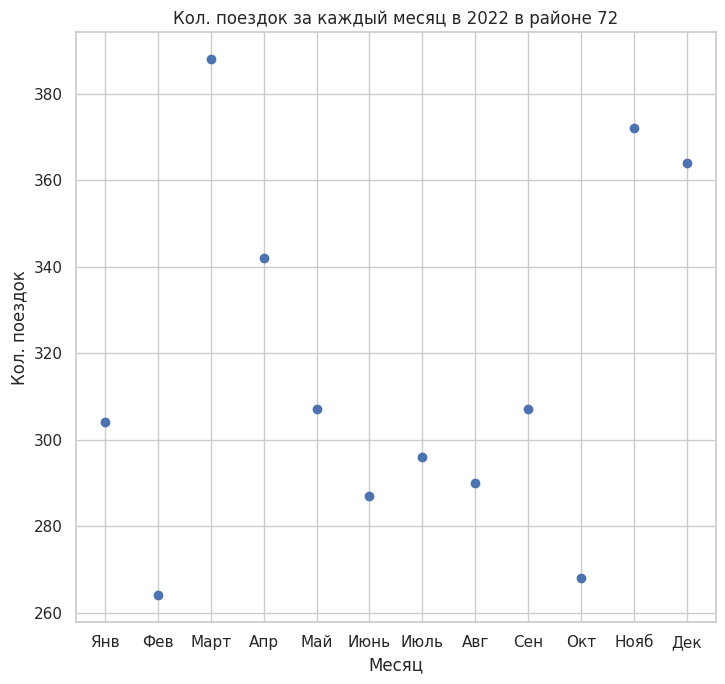

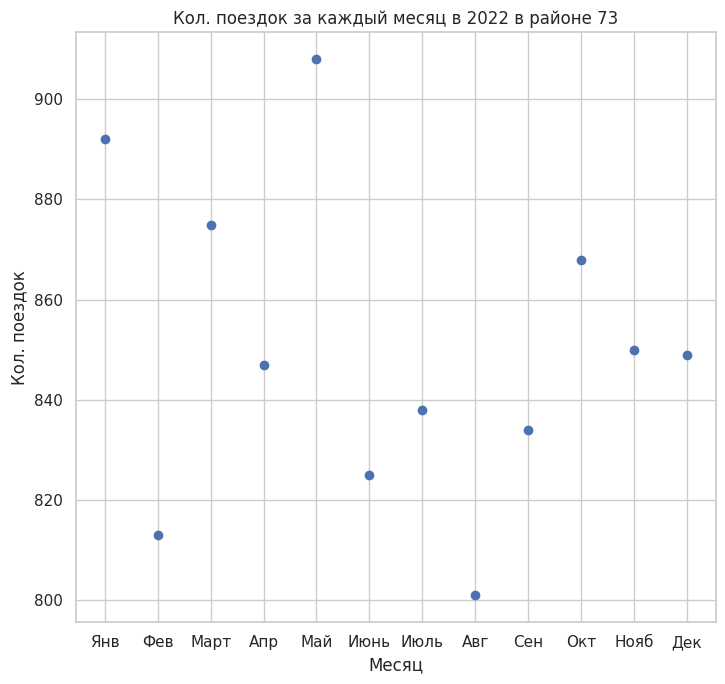

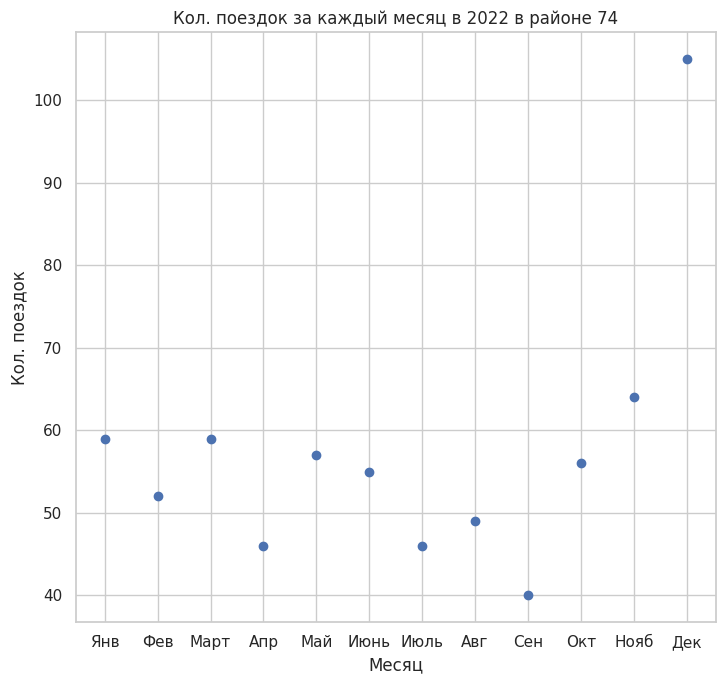

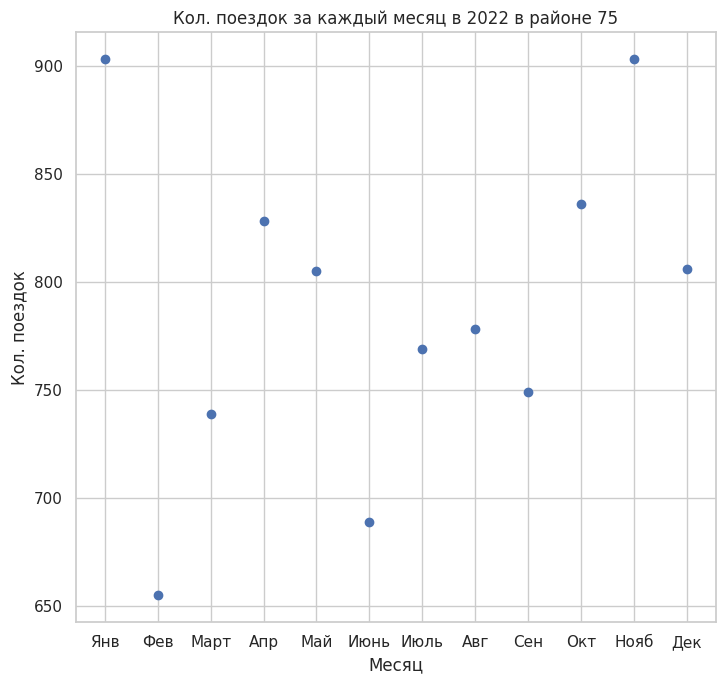

In [ ]:
print('Отдаленные юго-западные районы имеют мало данных, имеет смысл объеденить их в один регион')
plot_trips_by_month(df, 70)
plot_trips_by_month(df, 71)
plot_trips_by_month(df, 72)
plot_trips_by_month(df, 73)
plot_trips_by_month(df, 74)
plot_trips_by_month(df, 75)

Для отдаленных юго-восточных районов понадобится объедниение
для увеличения количества данных.


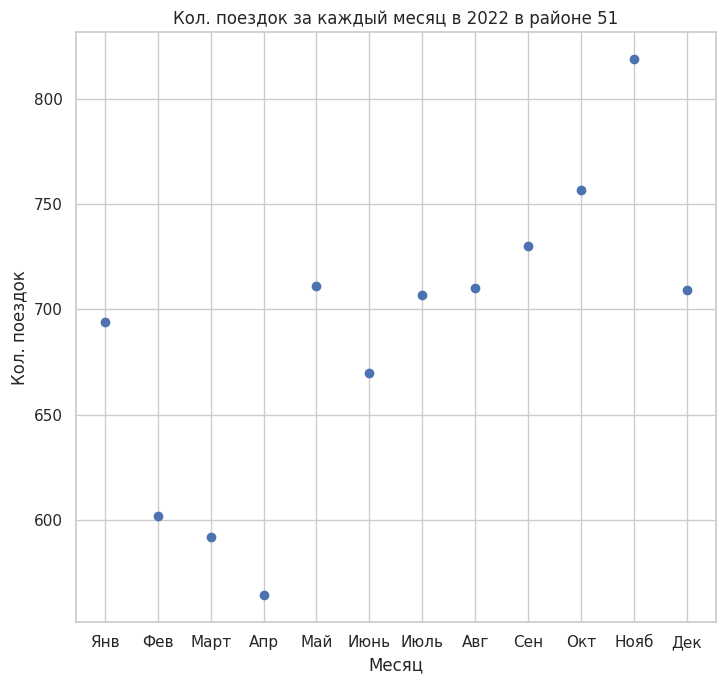

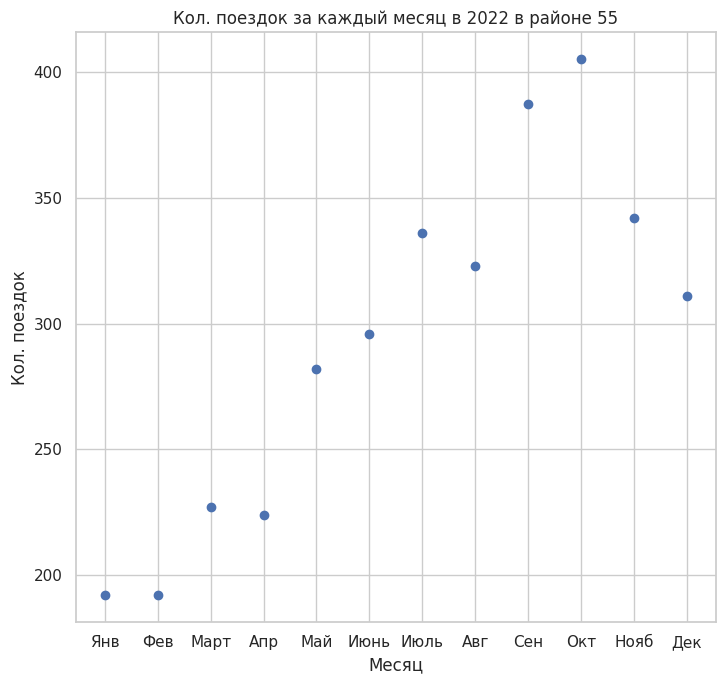

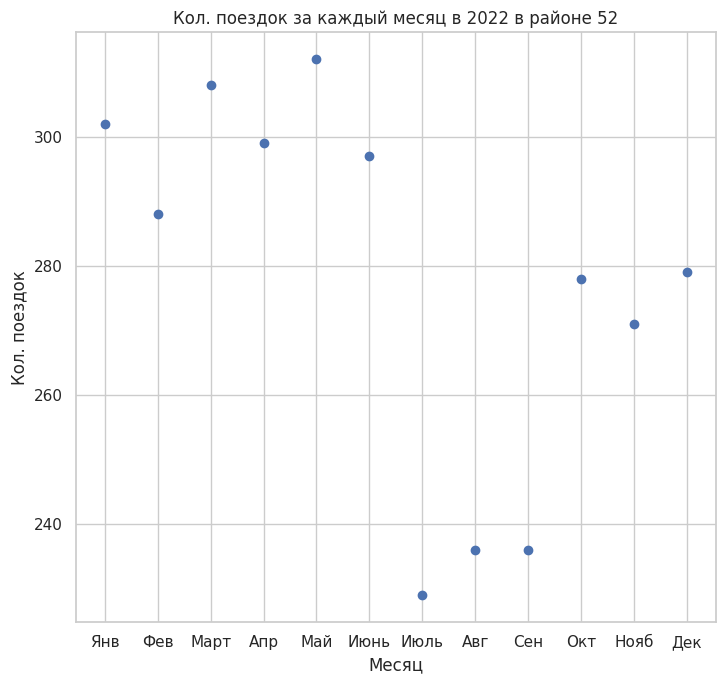

(None, None, None)

In [ ]:
print('Для отдаленных юго-восточных районов понадобится объедниение')
print('для увеличения количества данных.')
plot_trips_by_month(df, 51), plot_trips_by_month(df, 55), plot_trips_by_month(df, 52)

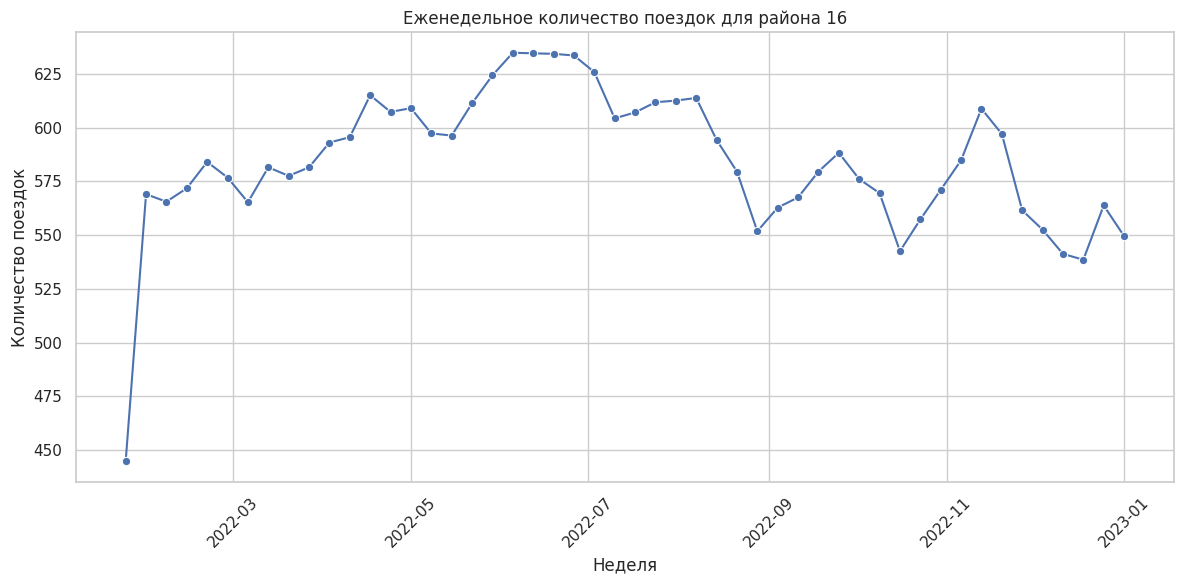

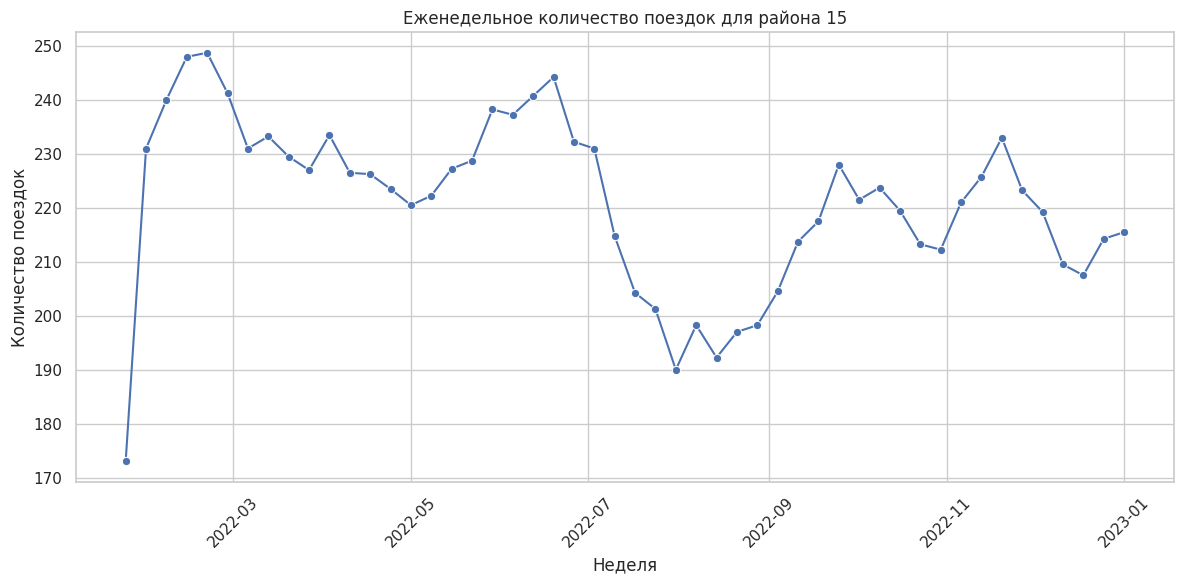

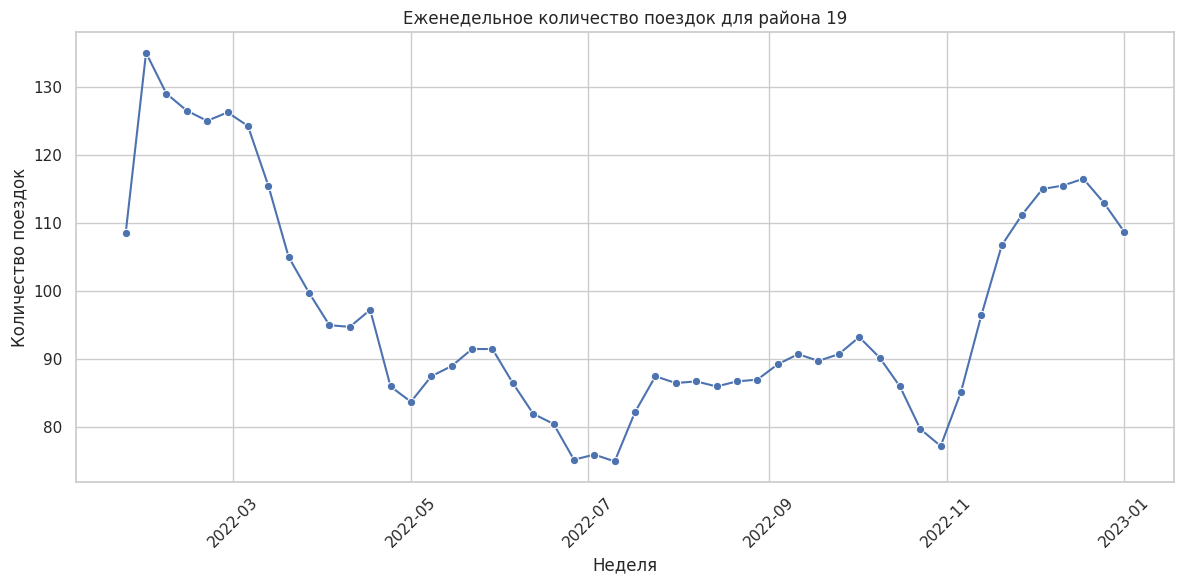

(None, None, None)

In [ ]:
plot_trips_by_year(df, 16), plot_trips_by_year(df, 15), plot_trips_by_year(df, 19)

### Вывод по графикам:
Мы выбрали район с большим количеством заказов и с одним из наименьших. В сраднем у районов пик заказов утром в начале рабочего дня, в обед и конец рабочего дня. Рост числа заказов в центральных районах растет от начала года к концу лета, а в менее населенных районах весна и лето наименее популярное время для такси.


## Подготовка данных

Сгруппируем данные по регионам. Это не сильно повлияет на точность модели, так как поведение в густонаселенных райнах схожи. Районы, где данных меньше, это поможет улучшить точность предсказания.

In [ ]:
# Условие для замены значений
farnorth = F.when(F.col('pickup_community_area').isin(77, 2, 3, 4, 9, 10, 11, 12, 13, 14, 76), 1).otherwise(F.col('pickup_community_area'))
north = F.when(F.col('pickup_community_area').isin(5, 6, 7, 21, 22), 2).otherwise(F.col('pickup_community_area'))
northwest = F.when(F.col('pickup_community_area').isin(15, 16, 17, 18, 19, 20), 3).otherwise(F.col('pickup_community_area'))
central = F.when(F.col('pickup_community_area').isin(8, 32, 33), 4).otherwise(F.col('pickup_community_area'))
west = F.when(F.col('pickup_community_area').isin(23, 24, 25, 26, 27, 28, 29, 30, 31), 5).otherwise(F.col('pickup_community_area'))
south = F.when(F.col('pickup_community_area').isin(34, 35, 36, 37, 38, 39, 40, 41, 42, 60, 69, 43), 6).otherwise(F.col('pickup_community_area'))
farsouthheast = F.when(F.col('pickup_community_area').isin(44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55), 7).otherwise(F.col('pickup_community_area'))
southwest = F.when(F.col('pickup_community_area').isin(56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68), 8).otherwise(F.col('pickup_community_area'))
farsouthwest = F.when(F.col('pickup_community_area').isin(70, 71, 72, 73, 74, 75), 9).otherwise(F.col('pickup_community_area'))


# Применение условия к столбцу "area"
df = df.withColumn('pickup_community_area', farnorth)
df = df.withColumn('pickup_community_area', north)
df = df.withColumn('pickup_community_area', northwest)
df = df.withColumn('pickup_community_area', central)
df = df.withColumn('pickup_community_area', west)
df = df.withColumn('pickup_community_area', south)
df = df.withColumn('pickup_community_area', farsouthheast)
df = df.withColumn('pickup_community_area', southwest)
df = df.withColumn('pickup_community_area', farsouthwest)


In [ ]:
# Преобразование времени до уровня часа
df = df.withColumn('HourlyTimestamp', date_format('trip_start_timestamp', 'yyyy-MM-dd HH'))

# Агрегация данных для подсчета числа заказов в каждом часовом интервале и каждом районе
aggregated_df = df.groupBy(['HourlyTimestamp', 'pickup_community_area']).count().withColumnRenamed('count', 'NumberOfOrders')

# Сортировка данных по времени и району может быть полезной
aggregated_df = aggregated_df.orderBy(['HourlyTimestamp', 'pickup_community_area'])


Не во все часы были заказы, но об этом нет информации в датасете, добавим её сами. Это поможет нам лучше обучить модель

In [ ]:
# Создаем DataFrame со всеми часовыми интервалами
start_time = datetime.strptime('2022-01-01 00', '%Y-%m-%d %H')
end_time = datetime.strptime('2023-08-01 00', '%Y-%m-%d %H')

all_hours = []
while start_time < end_time:
    all_hours.append(start_time.strftime('%Y-%m-%d %H'))
    start_time += timedelta(hours=1)

all_hours_df = spark.createDataFrame([(t,) for t in all_hours], ['HourlyTimestamp'])

# Создаем DataFrame с номерами районов
all_areas = list(range(1, 10))
all_areas_df = spark.createDataFrame([(a,) for a in all_areas], ['pickup_community_area'])

# Создаем все возможные комбинации часовых интервалов и районов
all_combinations_df = all_hours_df.crossJoin(all_areas_df)

In [ ]:
aggregated_df = df.groupBy('HourlyTimestamp', 'Pickup Community Area').count().withColumnRenamed('count', 'NumberOfOrders')

final_df = all_combinations_df.join(aggregated_df, ['HourlyTimestamp', 'Pickup Community Area'], 'left_outer')

# Заполняем пропущенные значения
final_df = final_df.na.fill(0)

## Инжиниринг признаков

In [ ]:
# Агрегируем нужные статистические признаки
features_df = df.groupBy("HourlyTimestamp", "pickup_community_area").agg(
    F.mean("trip_seconds").alias("mean_trip_seconds"),
    F.mean("trip_miles").alias("mean_trip_miles"),
    F.mean("fare").alias("mean_fare"),
    F.mean("tips").alias("mean_tips"),
    F.mean("tolls").alias("mean_tolls"),
    F.mean("extras").alias("mean_extras")
)


In [ ]:
# Функция для нахождения моды
def mode_of_group(df, group_cols, agg_col):
    # Подсчет количества каждого значения в agg_col для каждой группы в group_cols
    count_df = df.groupBy(group_cols + [agg_col]).count()

    # Оконная функция для нахождения максимального количества в каждой группе
    window = Window.partitionBy(group_cols).orderBy(F.desc("count"))

    # Выбор значения с максимальным количеством для каждой группы
    mode_df = count_df.withColumn("rank", F.rank().over(window)) \
                      .filter(F.col("rank") == 1) \
                      .drop("count", "rank")

    return mode_df

In [ ]:
# Применение функции для нахождения моды для  и 'Company'
mode_company = mode_of_group(df, ["HourlyTimestamp", "pickup_community_area"], "company").withColumnRenamed("company", "mode_company_mode")

In [ ]:
# Объединение моды с исходным DataFrame
features_df = features_df.join(mode_company, ["HourlyTimestamp", "pickup_community_area"], "left_outer")

# Объединяем с final_df
final_df = final_df.join(features_df, ["HourlyTimestamp", "pickup_community_area"], "left_outer")

# Заполняем пропущенные значения
final_df = final_df.na.fill({
    "mean_trip_seconds": 0,
    "mean_trip_miles": 0,
    "mean_fare": 0,
    "mean_tips": 0,
    "mean_tolls": 0,
    "mean_extras": 0,
    "mode_company_mode": "Unknown"
})


In [ ]:
final_df = final_df.withColumn("HourOfDay", F.hour("HourlyTimestamp"))
final_df = final_df.withColumn("DayOfWeek", F.date_format("HourlyTimestamp", 'E'))
final_df = final_df.withColumn("Month", F.month("HourlyTimestamp"))
final_df = final_df.withColumn("Year", F.year("HourlyTimestamp"))

In [ ]:
# Определяем окно с сортировкой по времени и району
windowSpec = Window.partitionBy("pickup_community_area").orderBy("HourlyTimestamp")

# Создаем lag features для 'NumberOfOrders'
final_df = final_df.withColumn("Lag1NumberOfOrders", F.lag("NumberOfOrders", 1).over(windowSpec))
final_df = final_df.withColumn("Lag2NumberOfOrders", F.lag("NumberOfOrders", 2).over(windowSpec))
final_df = final_df.withColumn("Lag24NumberOfOrders", F.lag("NumberOfOrders", 24).over(windowSpec))
final_df = final_df.withColumn("Lag48NumberOfOrders", F.lag("NumberOfOrders", 48).over(windowSpec))

# Заполняем пропущенные значения
final_df = final_df.na.fill({"Lag1NumberOfOrders": 0, "Lag2NumberOfOrders": 0, "Lag24NumberOfOrders": 0, "Lag48NumberOfOrders": 0})


In [ ]:
# Вычисляем скользящее среднее по последним 3 значениям для 'NumberOfOrders'
final_df = final_df.withColumn("MovingAvgNumberOfOrders", F.avg("NumberOfOrders").over(windowSpec.rowsBetween(-3, -1)))

# Заполняем пропущенные значения
final_df = final_df.na.fill({"MovingAvgNumberOfOrders": 0})


In [ ]:
final_df.printSchema()

root
 |-- HourlyTimestamp: string (nullable = true)
 |-- Pickup Community Area: long (nullable = true)
 |-- NumberOfOrders: long (nullable = true)
 |-- MeanTripSeconds: double (nullable = false)
 |-- MeanTripMiles: double (nullable = false)
 |-- MeanFare: double (nullable = false)
 |-- MeanTips: double (nullable = false)
 |-- MeanTolls: double (nullable = false)
 |-- MeanExtras: double (nullable = false)
 |-- PaymentType: string (nullable = false)
 |-- Company: string (nullable = false)
 |-- HourOfDay: integer (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Lag1NumberOfOrders: long (nullable = false)
 |-- Lag2NumberOfOrders: long (nullable = false)
 |-- Lag24NumberOfOrders: long (nullable = false)
 |-- Lag48NumberOfOrders: long (nullable = false)
 |-- MovingAvgNumberOfOrders: double (nullable = false)



In [ ]:
final_df.show()

+---------------+---------------------+--------------+-----------------+------------------+------------------+------------------+----------+-------------------+--------------------+---------+---------+-----+----+------------------+------------------+-------------------+-------------------+-----------------------+
|HourlyTimestamp|pickup_community_area|NumberOfOrders|mean_trip_seconds|   mean_trip_miles|         mean_fare|         mean_tips|mean_tolls|        mean_extras|   mode_company_mode|HourOfDay|DayOfWeek|Month|Year|Lag1NumberOfOrders|Lag2NumberOfOrders|Lag24NumberOfOrders|Lag48NumberOfOrders|MovingAvgNumberOfOrders|
+---------------+---------------------+--------------+-----------------+------------------+------------------+------------------+----------+-------------------+--------------------+---------+---------+-----+----+------------------+------------------+-------------------+-------------------+-----------------------+
|  2022-01-01 00|                    5|            68|6

## Кодирование данных

In [ ]:
# Исходный DataFrame
categorical_columns = ["mode_company_mode", "DayOfWeek"]  # Список категориальных столбцов

for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}Index")
    final_df = indexer.fit(final_df).transform(final_df)

    encoder = OneHotEncoder(inputCol=f"{col}Index", outputCol=f"{col}Vec")
    final_df = encoder.fit(final_df).transform(final_df)

# df теперь содержит индексированные и one-hot encoded столбцы



In [ ]:
# Список признаков для векторизации
feature_columns = ['HourOfDay',
                   'mean_trip_seconds',
                   'mean_trip_miles',
                   'mean_fare',
                   'mean_tips',
                   'mean_tolls',
                   'mean_extras',
                   'mode_company_modeVec',
                   'HourOfDay',
                   'DayOfWeekVec',
                   'Month',
                   'Year',
                   'Lag1NumberOfOrders',
                   'Lag2NumberOfOrders',
                   'Lag24NumberOfOrders',
                   'Lag48NumberOfOrders',
                   'MovingAvgNumberOfOrders']

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
vectorized_df = assembler.transform(final_df)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(vectorized_df)
df_scaled = scaler_model.transform(vectorized_df)

In [ ]:
df_scaled.show()

+---------------+---------------------+--------------+-----------------+-------------------+------------------+------------------+----------+------------------+--------------------+---------+---------+-----+----+------------------+------------------+-------------------+-------------------+-----------------------+----------------------+--------------------+--------------+-------------+--------------------+--------------------+
|HourlyTimestamp|pickup_community_area|NumberOfOrders|mean_trip_seconds|    mean_trip_miles|         mean_fare|         mean_tips|mean_tolls|       mean_extras|   mode_company_mode|HourOfDay|DayOfWeek|Month|Year|Lag1NumberOfOrders|Lag2NumberOfOrders|Lag24NumberOfOrders|Lag48NumberOfOrders|MovingAvgNumberOfOrders|mode_company_modeIndex|mode_company_modeVec|DayOfWeekIndex| DayOfWeekVec|            features|      scaledFeatures|
+---------------+---------------------+--------------+-----------------+-------------------+------------------+------------------+----------

In [ ]:
# Оставляем только нужные столбцы
df_scaled = df_scaled.select("HourlyTimestamp","pickup_community_area", "scaledFeatures", "NumberOfOrders")

In [ ]:
# Подсчет общего количества строк
total_rows = df_scaled.count()

# Размеры тренировочной, валидационной и тестовой выборок
train_size = int(total_rows * 0.7)
valid_size = int(total_rows * 0.2)
test_size = int(total_rows * 0.1)

# Разделение данных
train_data = df_scaled.limit(train_size)
valid_data = df_scaled.subtract(train_data).limit(valid_size)
test_data = df_scaled.subtract(train_data).subtract(valid_data)


In [ ]:
def check_overlap(data1, data2, names=("Dataset1", "Dataset2")):
    overlap = data1.intersect(data2)
    if overlap.count() > 0:
        print(f"There is an overlap between {names[0]} and {names[1]}!")
    else:
        print(f"No overlap between {names[0]} and {names[1]}.")

# Проверка перекрытий между различными датасетами
check_overlap(train_data, valid_data, ("train_data", "valid_data"))
check_overlap(train_data, test_data, ("train_data", "test_data"))
check_overlap(valid_data, test_data, ("valid_data", "test_data"))

No overlap between train_data and valid_data.
No overlap between train_data and test_data.
No overlap between valid_data and test_data.


Между соответствующими датасетами перекрытий нет, можно обучать модели.

## Обучение LinearRegression

In [ ]:
# Получение списка уникальных районов
unique_areas = train_data.select("pickup_community_area").distinct().rdd.flatMap(lambda x: x).collect()
unique_areasone = unique_areas
# Инициализация словаря для хранения моделей
area_models = {}

In [ ]:
for area in unique_areasone:
    # Фильтрация данных для конкретного района
    area_data = train_data.filter(train_data.pickup_community_area == area)

    # Обучение модели линейной регрессии
    lr = LinearRegression(featuresCol='scaledFeatures', labelCol='NumberOfOrders')
    lr_model = lr.fit(area_data)

    # Сохранение модели (если нужно)
    #lr_model.save(f"lr_model_area_{area}")

    # Добавление модели в словарь
    area_lr_models[area] = lr_model
    print(f"one more ml {area}")

one more ml 4
one more ml 8
one more ml 7
one more ml 1
one more ml 9
one more ml 3
one more ml 2
one more ml 6
one more ml 5


In [ ]:
# Инициализация оценщика
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumberOfOrders", metricName="rmse")

# Словарь для хранения результатов RMSE для каждого района
area_rmse = {}

In [ ]:
for area, model in area_lr_models.items():
    predictions = model.transform(valid_data.filter(valid_data.pickup_community_area == area))

    # Проверка, что DataFrame не пустой
    if predictions.count() == 0:
        print(f"No predictions for area {area}")
        continue

    try:
        # Оценка модели
        rmse = evaluator.evaluate(predictions)
        area_rmse[area] = rmse
        print(f"RMSE for area {area}: {rmse}")
    except Exception as e:
        print(f"Error evaluating area {area}: {e}")


RMSE for area 4: 10.653876772999427
RMSE for area 8: 2.140634354627859
RMSE for area 7: 0.5435463116020102
RMSE for area 1: 4.652446620805696
RMSE for area 9: 0.29998146924861285
RMSE for area 3: 0.31177708942907834
RMSE for area 2: 2.6170689121062627
RMSE for area 6: 1.0731592643342431
RMSE for area 5: 4.487238624643677


Мы получили не плохие результаты на валидационной выборке. Простая модель линейной регрессии может справиться с задачей прогнозирования количества заказов такси.

## Обучение GBTRegressor

In [ ]:
# Получение списка уникальных районов
unique_areas = train_data.select("pickup_community_area").distinct().rdd.flatMap(lambda x: x).collect()
unique_areasone = unique_areas
# Инициализация словаря для хранения моделей
area_models = {}

In [ ]:
for area in unique_areasone:
    # Фильтрация данных для конкретного района
    area_data = train_data.filter(train_data.pickup_community_area == area)

    # Обучение модели линейной регрессии
    gbt = GBTRegressor(featuresCol='scaledFeatures', labelCol='NumberOfOrders', maxDepth=4, maxIter=30)
    gbt_model = gbt.fit(area_data)

    # Сохранение модели
    #gbt_model.save(f"gbt_model_area_{area}")

    # Добавление модели в словарь
    area_gbt_models[area] = gbt_model
    print(f"one more ml {area}")

one more ml 4
one more ml 8
one more ml 7
one more ml 1
one more ml 9
one more ml 3
one more ml 2
one more ml 6
one more ml 5


In [ ]:
# Инициализация оценщика
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumberOfOrders", metricName="rmse")

# Словарь для хранения результатов RMSE для каждого района
area_rmse = {}

In [ ]:
for area, model in area_gbt_models.items():
    predictions = model.transform(valid_data.filter(valid_data.pickup_community_area == area))

    # Проверка, что DataFrame не пустой
    if predictions.count() == 0:
        print(f"No predictions for area {area}")
        continue

    try:
        # Оценка модели
        rmse = evaluator.evaluate(predictions)
        area_rmse[area] = rmse
        print(f"RMSE for area {area}: {rmse}")
    except Exception as e:
        print(f"Error evaluating area {area}: {e}")


RMSE for area 4: 7.884685507204978
RMSE for area 8: 0.8351222030738449
RMSE for area 7: 0.2883533579959636
RMSE for area 1: 3.5077243073388584
RMSE for area 9: 0.12670126496848785
RMSE for area 3: 0.4035851060638238
RMSE for area 2: 1.0543054066609368
RMSE for area 6: 0.778225446371874
RMSE for area 5: 2.119025026219687


GBTRegressor показал результат на валидационной выборке лучше, чем linearRegressor.

## Проверка на тестовой выборке

Проверим GBTRegressor как лучшую модель на тестовой выборке.  

In [ ]:
for area, model in area_gbt_models.items():
    predictions = model.transform(test_data.filter(valid_data.pickup_community_area == area))

    # Проверка DataFrame на пустоту
    if predictions.count() == 0:
        print(f"No predictions for area {area}")
        continue

    try:
        # Оценка модели
        rmse = evaluator.evaluate(predictions)
        area_rmse[area] = rmse
        print(f"RMSE for area {area}: {rmse}")
    except Exception as e:
        print(f"Error evaluating area {area}: {e}")

RMSE for area 4: 7.874987036029326
RMSE for area 8: 1.1746888023529631
RMSE for area 7: 0.29610131525388067
RMSE for area 1: 3.3451723698956712
RMSE for area 9: 0.13163469009319814
RMSE for area 3: 0.4044086524778585
RMSE for area 2: 1.0732949738240223
RMSE for area 6: 0.7770737539882095
RMSE for area 5: 2.3592037448174326


Результаты на тестовой выборке не сильно отличаются от результатов на валидацинной выборке. Модели успешно прошли проверку на тесте.

## Вывод по работе

Наша работа состоит из нескольких ключевых этапов:  

1. Подготовка данных: Начав с загрузки и объединения данных, мы провели исследовательский анализ, чтобы понять структуру данных и основные характеристики. Мы также уделили внимание предварительной обработке данных, включая обработку пропущенных значений и преобразование типов данных.  
2. Анализ данных: С помощью визуализаций мы исследовали тренды и колебания в поездках такси в разных районах Чикаго. Это позволило увидеть, как распределено количество поездок по часам, дням и месяцам.  
3. Инжиниринг признаков: Мы создали ряд новых признаков, таких как lag-признаки, чтобы улучшить производительность модели. Кроме того, мы провели кодирование категориальных переменных и масштабирование признаков.  
4. Обучение моделей: для каждого 9 сгруппированых районов была обучена отдельная модель линейной регрессии и GBTRegressor.  
5. Метрики: Модели были оценены с использованием метрики RMSE на валидационных и тестовых данных.

В целом, наш проект представляет собой тщательный анализ данных о поездках на такси в Чикаго и успешное применение моделей машинного обучения для прогнозирования будущего количества заказов. Мы использовали GBTRegressor для решения этой задачи и применили разные методы обработки и инжиниринга признаков для улучшения производительности моделей. Наш подход к обучению отдельной модели для группы районов позволяет учитывать уникальные особенности каждого района, что улучшает точность прогнозов.

## Рекомендации

Для улучшения предсказаний моделей:

1.   Использовать больше данных (в нашей выборке данные за 22 год, можно использовать ещё за 23г.)
2.   В идеале для каждого из 77 районов обучить свою модель на достаточном объеме данных.
3.   Использовать больше доп. фичей, таких как время  работы общественного транспорта, время обеда, конец рабочего дня, праздники и тд.
4.   Попробовать другие модели, возможно, catboost.

